# Sesión 15: Deep Dream

---

Viernes 10 de Noviembre de 2023

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

In [2]:
# URL of the image
url = 'https://www.hdcarwallpapers.com/walls/2021_porsche_911_turbo_4k_8k-HD.jpg'

In [3]:
# Convert image to numpy array
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

In [4]:
# Normalize image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

7817687/7817687 [==============================] - 2s 0us/step


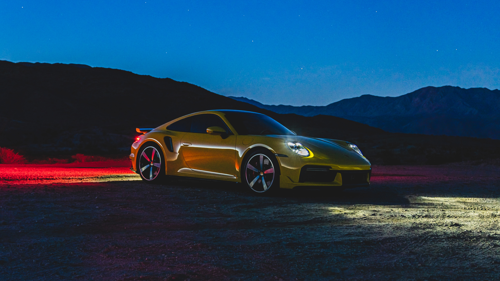

In [6]:
# Display image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
show(original_img)

In [7]:
# Load the InceptionV3 model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 3s 0us/step


In [8]:
# Extract the characteristics of the image from the intermediate layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [9]:
# Loss function
def calc_loss(img, model):
    # Pass the image through the model
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

In [10]:
# Gradient ascent

class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )

  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        # This needs gradients relative to `img`
        # `GradientTape` only watches `tf.Variable`s by default
        tape.watch(img)
        loss = calc_loss(img, self.model)

      # Calculate the gradient of the loss with respect to the pixels of the input image.
      gradients = tape.gradient(loss, img)

      # Normalize the gradients.
      gradients /= tf.math.reduce_std(gradients) + 1e-8 

      # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
      # You can update the image by directly adding the gradients (because they're the same shape!)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

    return loss, img

In [11]:
deepdream = DeepDream(dream_model)

In [13]:
# Main function to run the deep dream
def run_deep_dream_simple(img, steps = 100, step_size = 0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps

  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)

    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result
  

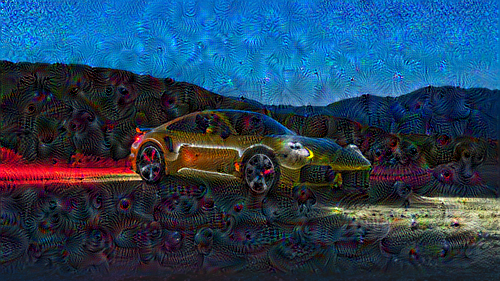

In [14]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

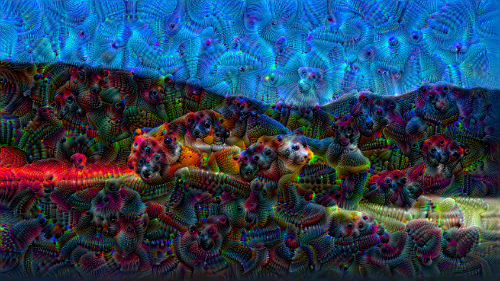

In [18]:
# Increase an octave
import time

start = time.time()
OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32) # Scale the image
  img = tf.image.resize(img, new_shape).numpy() # Resize the image
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01) # Run the deep dream

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()